In [2]:
import os
import gc
#import cv2
import math
import copy
import time
import random
import glob

# Plotting
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision


import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/mccruz/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
1

1

In [4]:
ROOT_DIR = "/home/mccruz/isic"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

CONFIG = {
    "seed": 42,
    "n_samples_train":3000,
    "n_samples_val":3000, 
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [5]:
seed=CONFIG['seed']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Data

In [6]:
train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")
test_df = pd.read_csv(ROOT_DIR+"/test-metadata.csv")

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
display(train_df.head())
display(test_df.head())

/tmp/ipykernel_1840142/1934611744.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(ROOT_DIR+"/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [8]:
train_images

['/home/mccruz/isic/train-image/image/ISIC_0015670.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0015845.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0015864.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0015902.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0024200.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0035502.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051648.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051665.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051710.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051758.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051812.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051822.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051896.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051897.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051958.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0051983.jpg',
 '/home/mccruz/isic/train-image/image/ISIC_0052003.jpg',
 '/home/mccruz/isic/train-image

In [9]:
## Images

def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

def show_im(image_id):
    image = mpimg.imread(image_id)
    plt.imshow(image)
    plt.show()

In [10]:
for i in range(10):
    image = mpimg.imread(train_images[i])
    print(image.shape)
    

(139, 139, 3)
(127, 127, 3)
(145, 145, 3)
(109, 109, 3)
(125, 125, 3)
(119, 119, 3)
(117, 117, 3)
(157, 157, 3)
(111, 111, 3)
(127, 127, 3)


In [20]:
df = train_df.copy()
df['image_path'] = df['isic_id'].apply(get_train_file_path)
#df['image'] = df['isic_id'].apply(show_im)
df = df[ df["image_path"].isin(train_images) ].reset_index(drop=True)


print("# of images , # of positive cases, # of negative cases, # of patients")
print(df.shape, df.target.sum(), (df["target"] == 0).sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

# of images , # of positive cases, # of negative cases, # of patients
(401059, 56) 393 400666 (1042,)


## EDA

In [21]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,image_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,/home/mccruz/isic/train-image/image/ISIC_00156...
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,/home/mccruz/isic/train-image/image/ISIC_00158...
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,/home/mccruz/isic/train-image/image/ISIC_00158...
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,/home/mccruz/isic/train-image/image/ISIC_00159...
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,/home/mccruz/isic/train-image/image/ISIC_00242...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,/home/mccruz/isic/train-image/image/ISIC_99999...
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,/home/mccruz/isic/train-image/image/ISIC_99999...
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,/home/mccruz/isic/train-image/image/ISIC_99999...
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,/home/mccruz/isic/train-image/image/ISIC_99999...


In [27]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

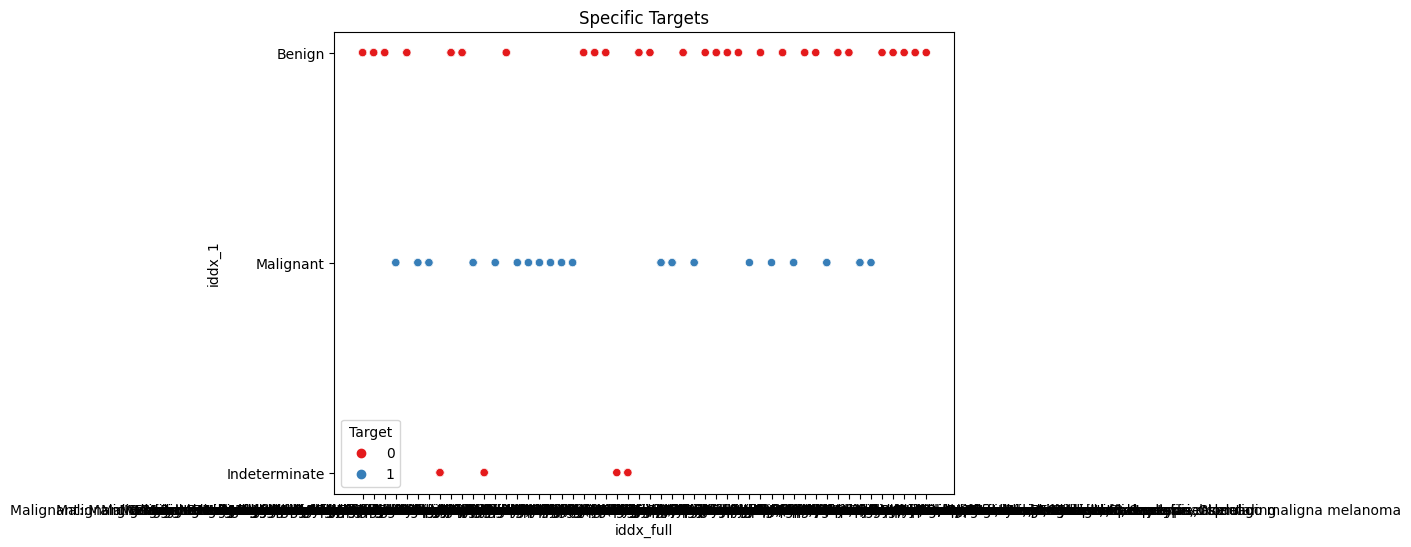

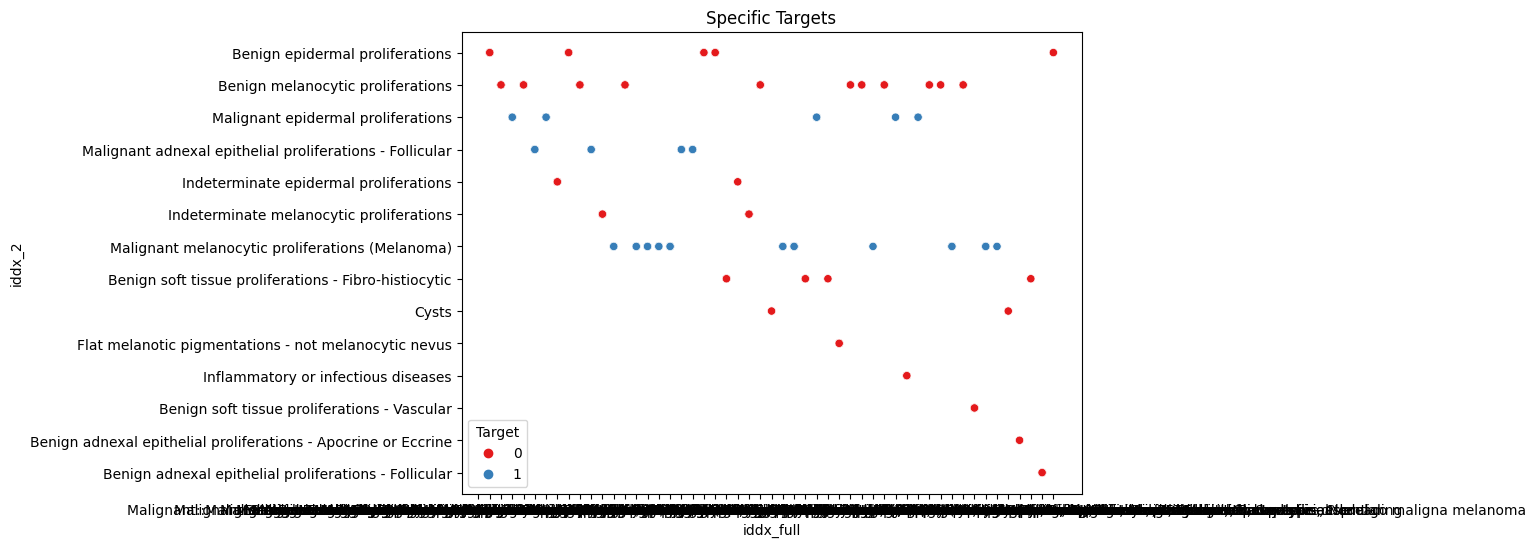

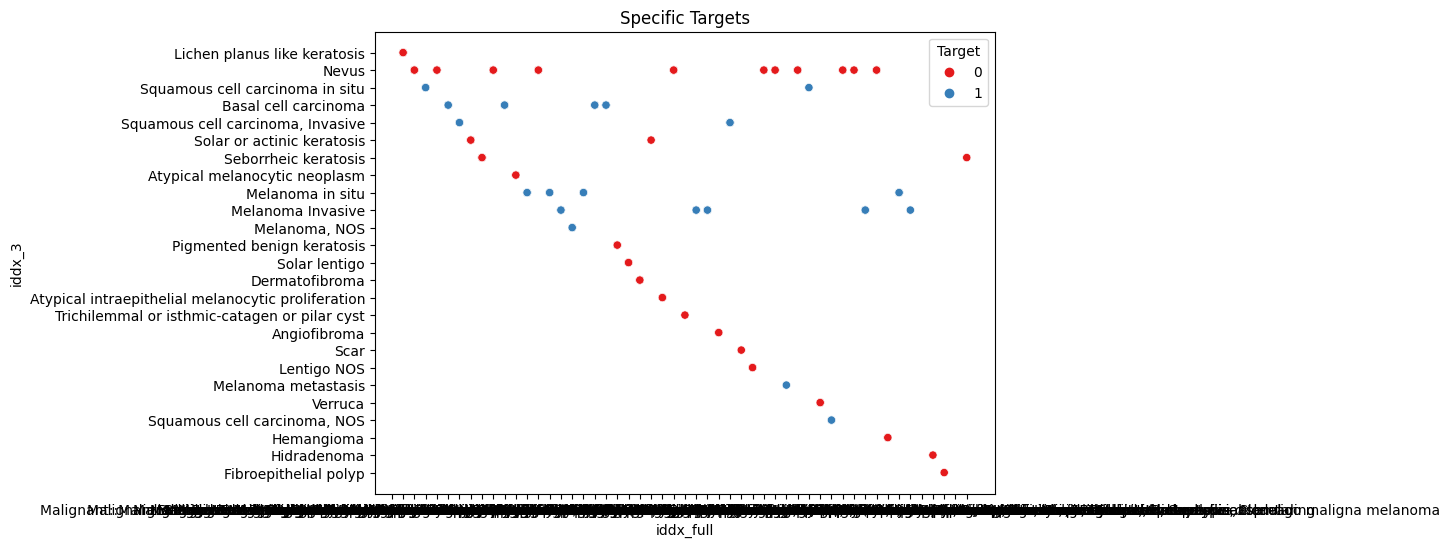

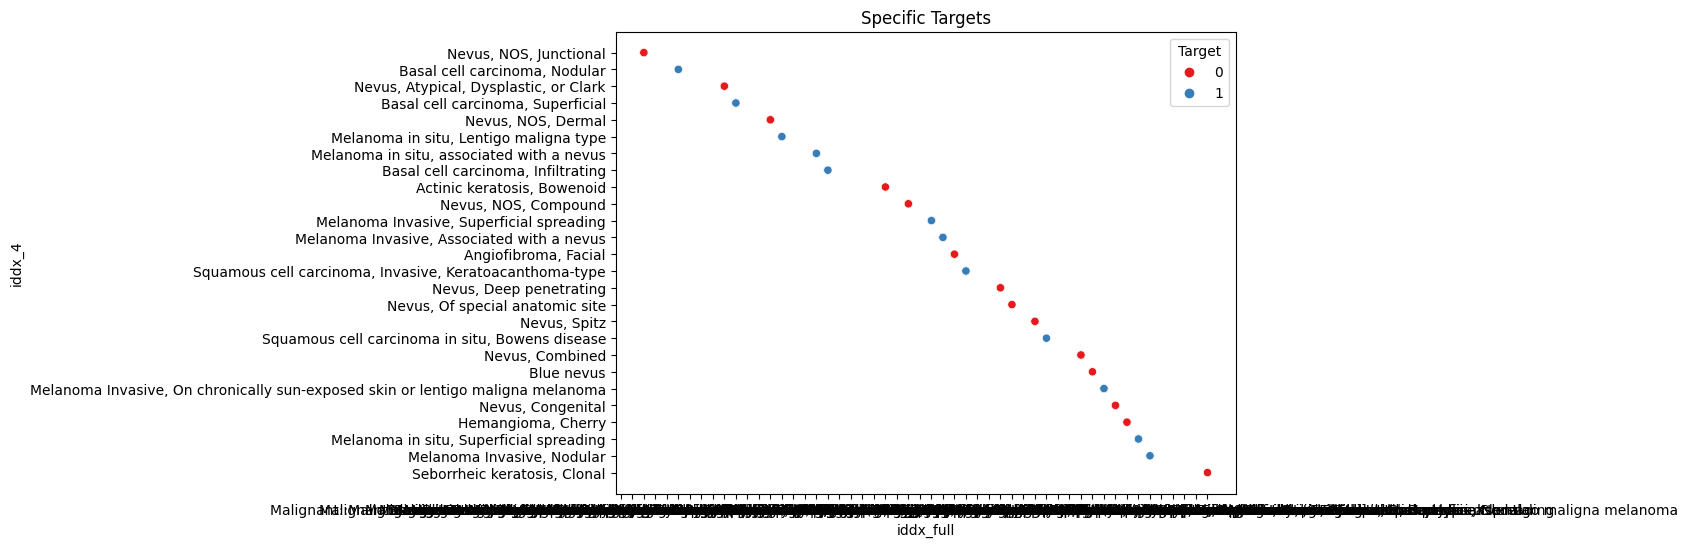

IndexError: list index out of range

<Figure size 800x600 with 0 Axes>

In [56]:
## Targets

targets_iddx = ['target','iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4']

for i in range(1,8):
    for j in range(i+1,8):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=targets_iddx[i], y=targets_iddx[j], hue='target', palette='Set1')
        plt.title('Specific Targets')
        plt.xlabel(targets_iddx[i])
        plt.ylabel(targets_iddx[j])
        plt.legend(title='Target')
        plt.show()

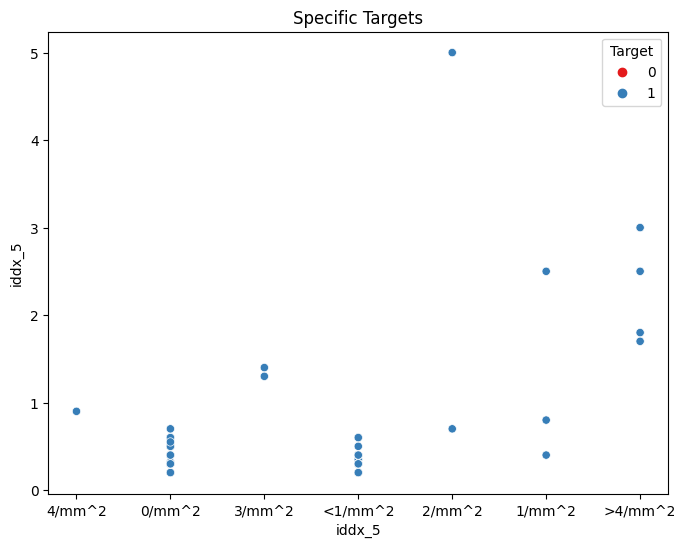

In [52]:
## Targets

## Specific to Target = 1: 'mel_mitotic_index', 'mel_thick_mm'

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='mel_mitotic_index', y= 'mel_thick_mm', hue='target', palette='Set1')
plt.title('Specific Targets')
plt.xlabel(targets_iddx[i])
plt.ylabel(targets_iddx[j])
plt.legend(title='Target')
plt.show()


In [121]:
# Continuous
cont_cols = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_dnn_lesion_confidence'] 

# Discrete/Categorical
disc_cols = ['patient_id', 'age_approx', 'sex', 'anatom_site_general', 'tbp_tile_type',  'tbp_lv_location', 'tbp_lv_location_simple']

## Probably not useful columns for metadata
other_cols = ['iddx_5', 'image_type', 'attribution', 'copyright_license', 'isic_id', 'lesion_id']

## To be used later
other_cols2 = ['tbp_lv_x', 'tbp_lv_y','tbp_lv_z']


In [122]:
for i in range(31):
        print(i, df_positive[cont_cols[i]].unique().shape, df_negative[cont_cols[i]].unique().shape, 
              df_positive[cont_cols[i]].unique().shape[0]+df_negative[cont_cols[i]].unique().shape[0], 
              df[cont_cols[i]].unique().shape,
             df_positive[cont_cols[i]].unique().shape[0]+df_negative[cont_cols[i]].unique().shape[0] - df[cont_cols[i]].unique().shape[0])

0 (301,) (1758,) 2059 (1758,) 301
1 (393,) (385683,) 386076 (386052,) 24
2 (393,) (384928,) 385321 (385304,) 17
3 (393,) (389509,) 389902 (389890,) 12
4 (393,) (387394,) 387787 (387763,) 24
5 (393,) (390323,) 390716 (390703,) 13
6 (393,) (388488,) 388881 (388865,) 16
7 (393,) (389419,) 389812 (389798,) 14
8 (393,) (390360,) 390753 (390743,) 10
9 (393,) (395343,) 395736 (395726,) 10
10 (393,) (395974,) 396367 (396358,) 9
11 (367,) (7993,) 8360 (8029,) 331
12 (390,) (167436,) 167826 (167648,) 178
13 (304,) (370891,) 371195 (371189,) 6
14 (393,) (397873,) 398266 (398257,) 9
15 (393,) (398499,) 398892 (398886,) 6
16 (393,) (396116,) 396509 (396505,) 4
17 (393,) (395130,) 395523 (395511,) 12
18 (393,) (396488,) 396881 (396877,) 4
19 (393,) (396263,) 396656 (396648,) 8
20 (362,) (75527,) 75889 (75669,) 220
21 (393,) (394859,) 395252 (395242,) 10
22 (393,) (390999,) 391392 (391372,) 20
23 (273,) (368473,) 368746 (368742,) 4
24 (362,) (9459,) 9821 (9492,) 329
25 (303,) (367267,) 367570 (367566

In [123]:
len(cont_cols)

31

/tmp/ipykernel_1840142/4119756817.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mccruz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


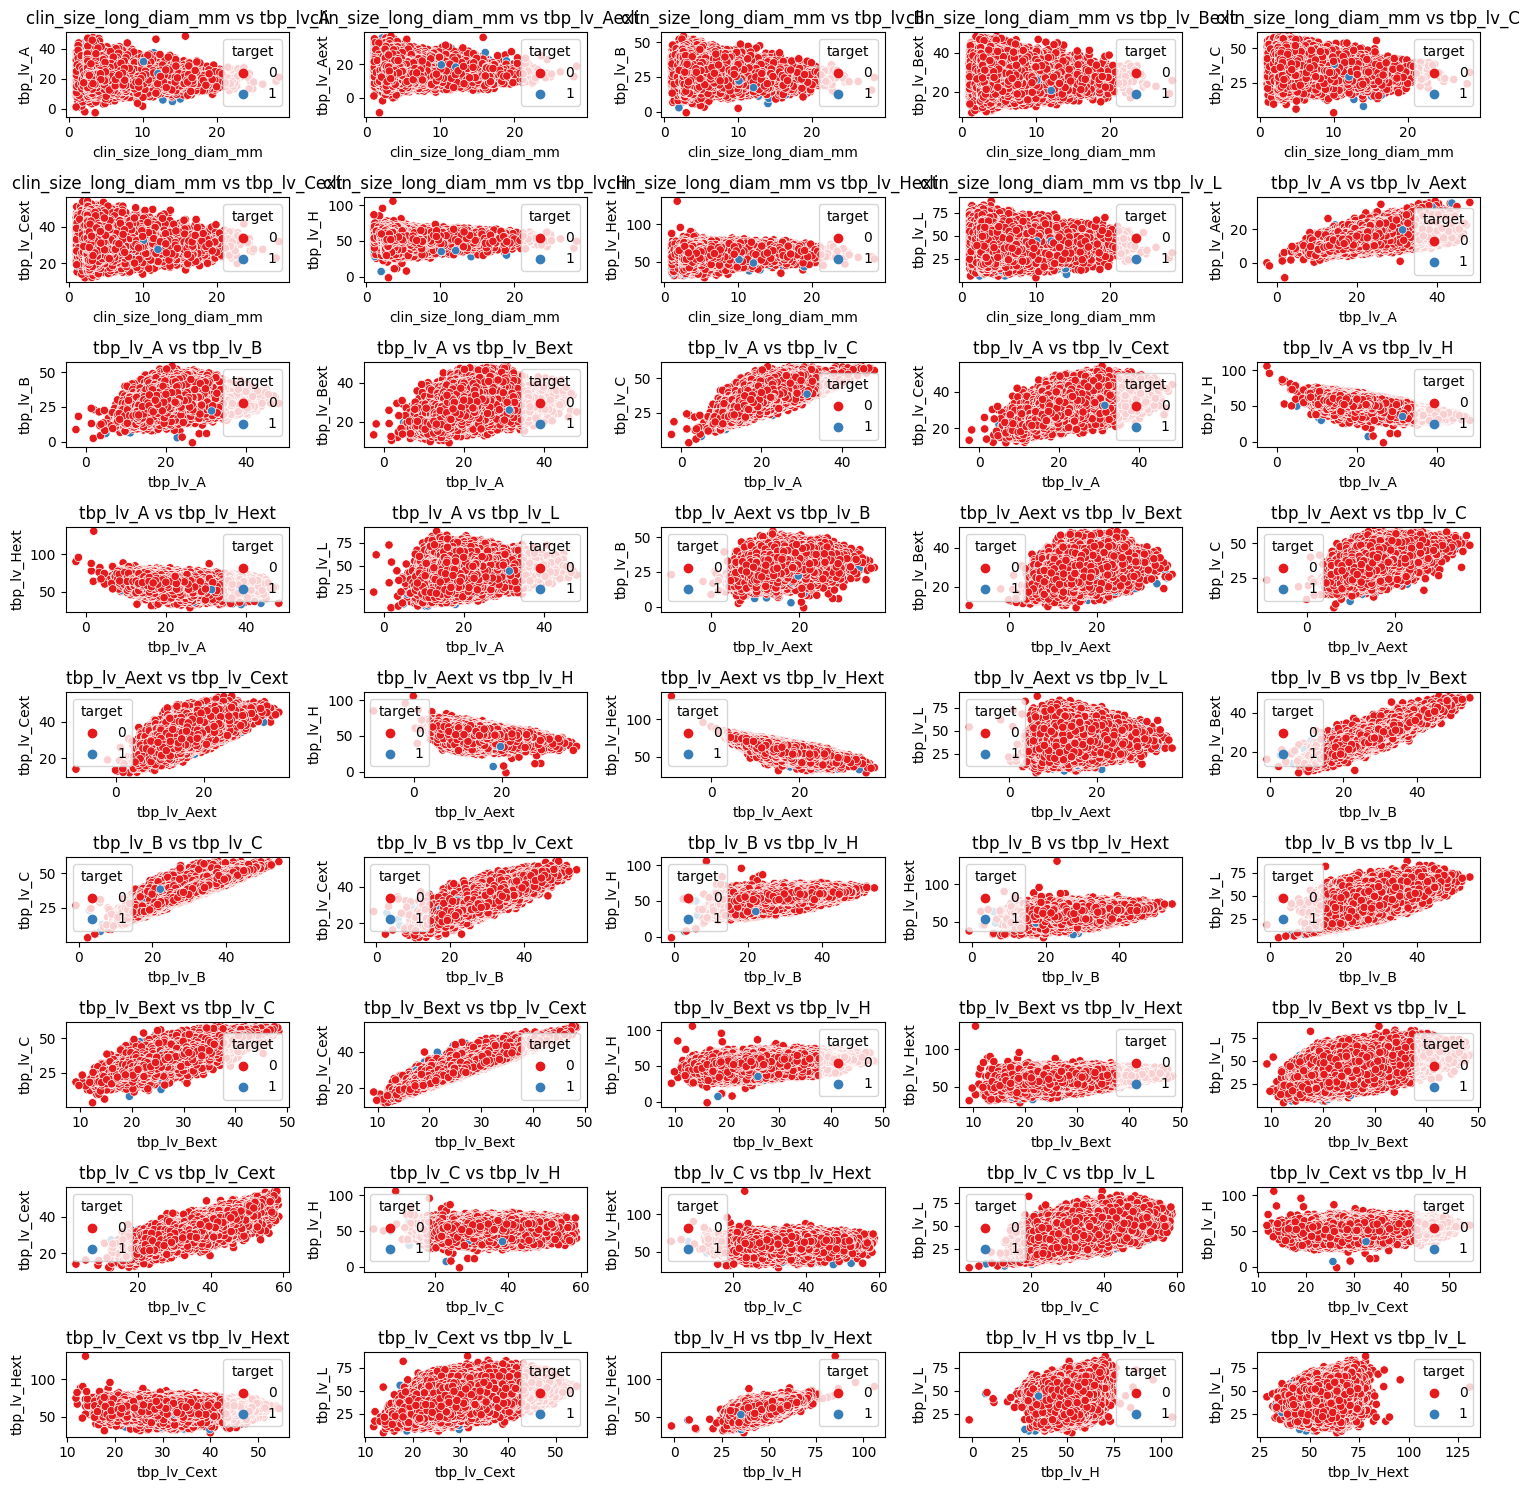

In [100]:
fig, axes = plt.subplots(9, 5, figsize=(15, 15))
axes = axes.flatten()

plot_index = 0
for i in range(10):
    for j in range(i+1,10):
        sns.scatterplot(data=df, x=cont_cols[i], y=cont_cols[j], hue='target', palette='Set1', ax=axes[plot_index])
        axes[plot_index].set_title(f'{cont_cols[i]} vs {cont_cols[j]}')
        axes[plot_index].set_xlabel(cont_cols[i])
        axes[plot_index].set_ylabel(cont_cols[j])
        plot_index += 1

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(9, 5, figsize=(15, 15))
axes = axes.flatten()

plot_index = 0
for i in range(10):
    for j in range(10,20):
        sns.scatterplot(data=df, x=cont_cols[i], y=cont_cols[j], hue='target', palette='Set1', ax=axes[plot_index])
        axes[plot_index].set_title(f'{cont_cols[i]} vs {cont_cols[j]}')
        axes[plot_index].set_xlabel(cont_cols[i])
        axes[plot_index].set_ylabel(cont_cols[j])
        plot_index += 1

plt.tight_layout()
plt.show()

## Start of Deep Learning: Pytorch

In [124]:
class ISICDataset(Dataset):
    def __init__(self, df, phase="train", transforms=None):
        if phase == 'train':
            offset = CONFIG["n_samples_val"]
            n_samples = CONFIG["n_samples_train"]
        elif phase == 'validation':
            offset = 0
            n_samples = CONFIG["n_samples_val"]

        self.df_positive = df[df["target"] == 1].reset_index(drop=True)
        self.df_negative = df[df["target"] == 0].reset_index(drop=True)
        
        # Shuffle and slice the DataFrame
        self.df_negative = self.df_negative.sample(frac=1, random_state=42).reset_index(drop=True)
        self.df_negative = df[offset:offset+n_samples-len(self.df_positive)]

        self.transforms = transforms
        self.n_samples = n_samples
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        if random.random() < len(self.df_positive) / (len(self.df_positive) + len(self.df_negative)):
            df = self.df_positive
        else:
            df = self.df_negative

        index = index % df.shape[0]
        
        img_path = df['image_path'].iloc[index]
        img = Image.open(img_path).convert("RGB")
        
        target = df['target'].iloc[index]
        
        if self.transforms:
            img = np.array(img)
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
 

In [125]:
## CHANGE THIS, GOT THIS FROM COMMUNITY MODELS

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "validation": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [126]:
train_dataset = ISICDataset(df, phase = "train", transforms=data_transforms["train"])
valid_dataset = ISICDataset(df, phase = "validation", transforms=data_transforms["validation"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                          num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

/home/mccruz/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [133]:
for batch in train_loader:
    print(batch['image'].shape, batch['target'])

torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])

In [134]:
batch['target']

tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [142]:
batch['image'][batch['target']==1,:,:,:].shape

torch.Size([2, 3, 384, 384])

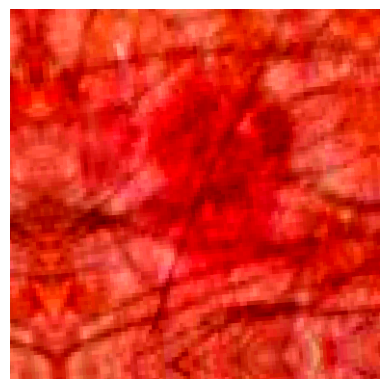

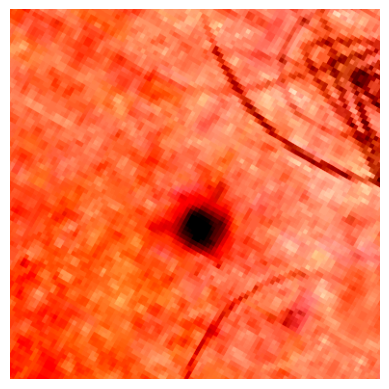

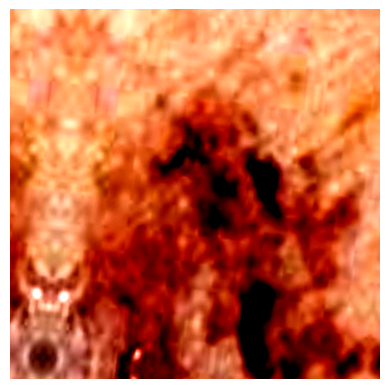

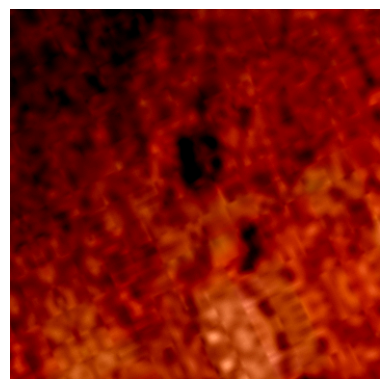

In [136]:
for i in range(4):
    image_array = batch['image'][batch['target']==1,:,:,:][i]
    if image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()

In [137]:
## CHANGE THIS, GOT THIS FROM COMMUNITY MODELS

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "validation": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [138]:
train_dataset = ISICDataset(df, phase = "train", transforms=data_transforms["train"])
valid_dataset = ISICDataset(df, phase = "validation", transforms=data_transforms["validation"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                          num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

In [139]:
for batch in train_loader:
    print(batch['image'].shape, batch['target'])

torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 384, 384]) tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

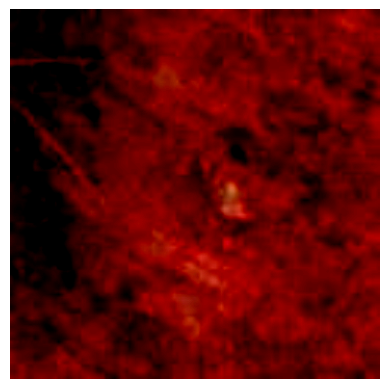

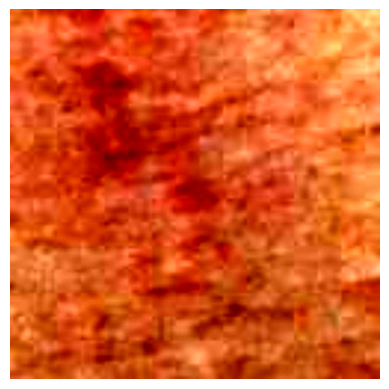

In [146]:
for i in range(2):
    image_array = batch['image'][batch['target']==1,:,:,:][i]
    if image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()